Benin Solar Data - Exploratory Data Analysis

In [13]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
benin_df = pd.read_csv('../data/benin-malanville.csv')
print("Dataset loaded successfully!")
print(f"Shape: {benin_df.shape}")

Dataset loaded successfully!
Shape: (525600, 19)


In [14]:
# Cell 2: Summary Statistics & Missing-Value Report
print("=== 1. SUMMARY STATISTICS & MISSING-VALUE REPORT ===")

# Basic info
print("\nDataset Info:")
print(benin_df.info())

# Summary statistics for numeric columns
print("\nSummary Statistics:")
numeric_cols = benin_df.select_dtypes(include=[np.number]).columns
print(benin_df[numeric_cols].describe())

# Missing value analysis
print("\nMissing Values Analysis:")
missing_summary = benin_df.isnull().sum()
missing_percentage = (benin_df.isnull().sum() / len(benin_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing Percentage': missing_percentage
})
print(missing_df)

# Identify columns with >5% nulls
high_missing_cols = missing_df[missing_df['Missing Percentage'] > 5].index.tolist()
print(f"\nColumns with >5% missing values: {high_missing_cols}")

=== 1. SUMMARY STATISTICS & MISSING-VALUE REPORT ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA 

In [16]:
# Cell 3: Outlier Detection
print("=== 2. OUTLIER DETECTION ===")

# Convert timestamp to datetime
benin_df['Timestamp'] = pd.to_datetime(benin_df['Timestamp'])

# Create a copy for cleaning
benin_clean = benin_df.copy()

# Define key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Function to detect outliers using Z-score
def detect_outliers_zscore(df, columns, threshold=3):
    outlier_flags = pd.DataFrame(index=df.index)
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outlier_flags[f'{col}_outlier'] = z_scores > threshold
    return outlier_flags

# Detect outliers
outlier_flags = detect_outliers_zscore(benin_clean, key_columns)
benin_clean = pd.concat([benin_clean, outlier_flags], axis=1)

# Count outliers
print("Outlier Count (|Z| > 3):")
for col in key_columns:
    if f'{col}_outlier' in outlier_flags.columns:
        outlier_count = outlier_flags[f'{col}_outlier'].sum()
        print(f"{col}: {outlier_count} outliers")

=== 2. OUTLIER DETECTION ===
Outlier Count (|Z| > 3):
GHI: 89 outliers
DNI: 0 outliers
DHI: 3738 outliers
ModA: 27 outliers
ModB: 63 outliers
WS: 3109 outliers
WSgust: 3500 outliers


In [17]:
# Cell 4: Data Cleaning
print("=== 3. DATA CLEANING ===")

# Create cleaning flags
benin_clean['cleaning_flag'] = 'original'
rows_before = len(benin_clean)

# Handle outliers - cap them instead of removing
for col in key_columns:
    if f'{col}_outlier' in benin_clean.columns:
        # Cap outliers to 3 standard deviations
        if col in benin_clean.columns:
            mean_val = benin_clean[col].mean()
            std_val = benin_clean[col].std()
            upper_limit = mean_val + 3 * std_val
            lower_limit = mean_val - 3 * std_val
            
            outliers_mask = benin_clean[f'{col}_outlier']
            benin_clean.loc[outliers_mask, col] = benin_clean.loc[outliers_mask, col].clip(
                lower=lower_limit, upper=upper_limit
            )
            benin_clean.loc[outliers_mask, 'cleaning_flag'] = 'cleaned'

# Impute missing values in key columns with median
key_columns_for_impute = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in key_columns_for_impute:
    if col in benin_clean.columns and benin_clean[col].isnull().sum() > 0:
        median_val = benin_clean[col].median()
        missing_mask = benin_clean[col].isnull()
        benin_clean.loc[missing_mask, col] = median_val
        benin_clean.loc[missing_mask, 'cleaning_flag'] = 'imputed'

print(f"Cleaning Summary:")
print(f"Rows before cleaning: {rows_before}")
print(f"Rows after cleaning: {len(benin_clean)}")
print(f"Cleaning flag distribution:")
print(benin_clean['cleaning_flag'].value_counts())

=== 3. DATA CLEANING ===
Cleaning Summary:
Rows before cleaning: 525600
Rows after cleaning: 525600
Cleaning flag distribution:
cleaning_flag
original    517860
cleaned       7740
Name: count, dtype: int64


=== 4. TIME SERIES ANALYSIS ===


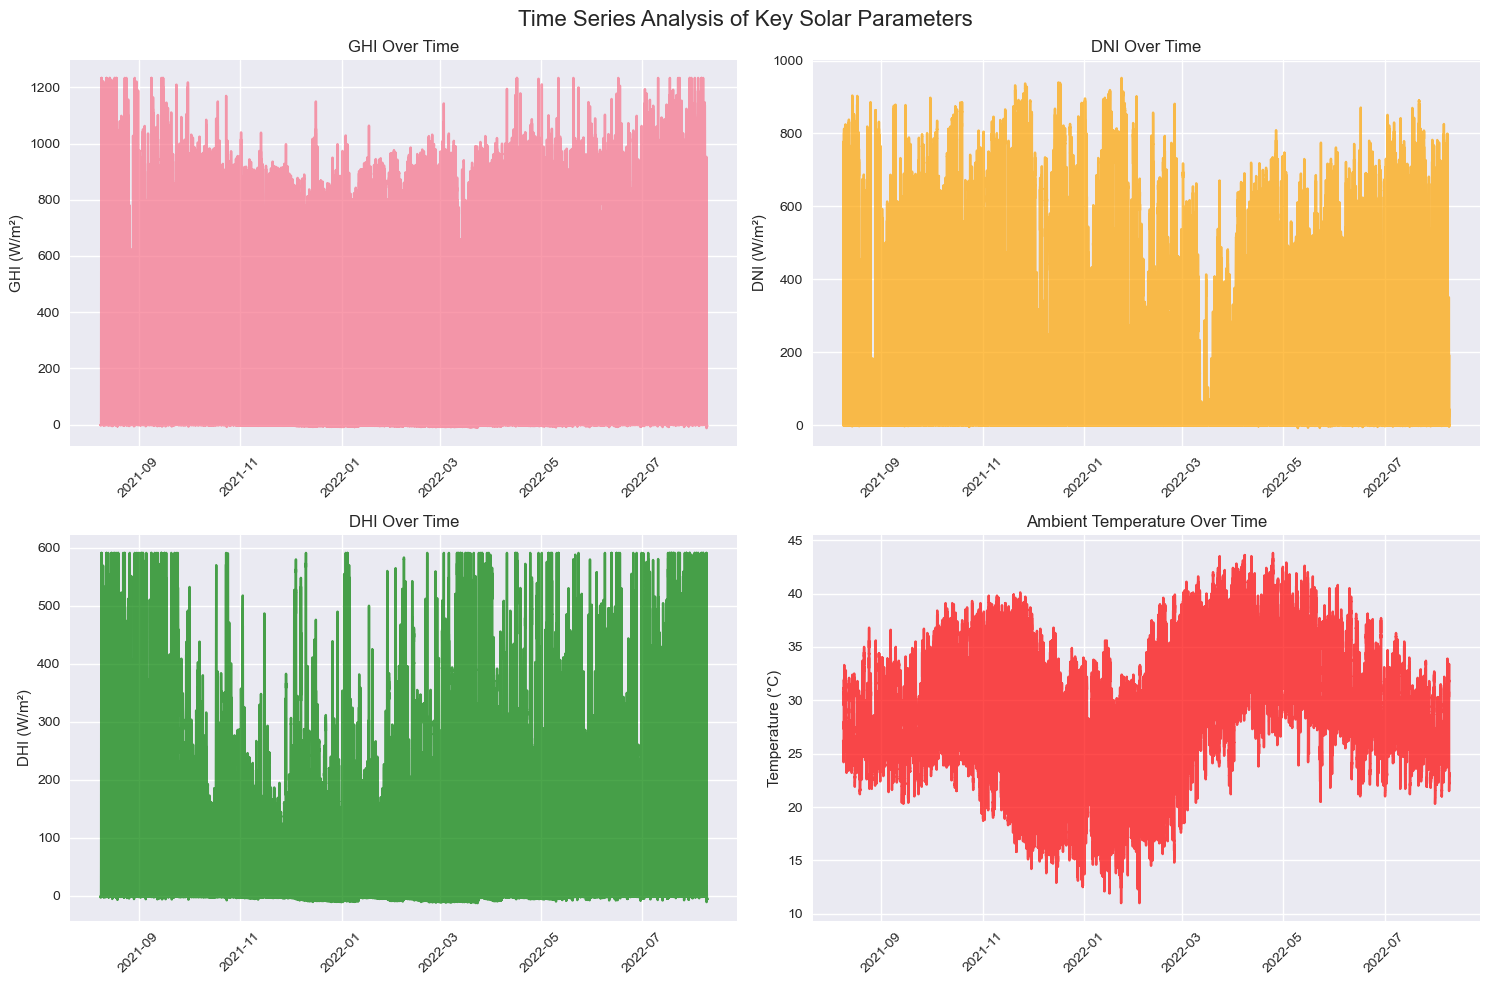

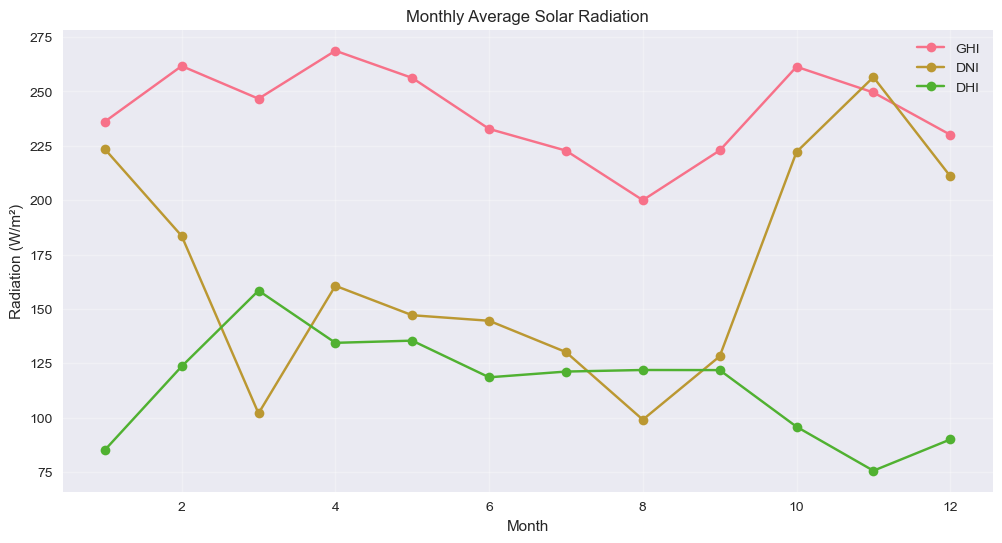

In [18]:
# Cell 5: Time Series Analysis
print("=== 4. TIME SERIES ANALYSIS ===")

# Set timestamp as index for time series analysis
benin_clean.set_index('Timestamp', inplace=True)

# Create time-based features
benin_clean['hour'] = benin_clean.index.hour
benin_clean['month'] = benin_clean.index.month
benin_clean['day_of_year'] = benin_clean.index.dayofyear

# Plot time series of key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series Analysis of Key Solar Parameters', fontsize=16)

# GHI over time
axes[0,0].plot(benin_clean.index, benin_clean['GHI'], alpha=0.7)
axes[0,0].set_title('GHI Over Time')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].tick_params(axis='x', rotation=45)

# DNI over time
axes[0,1].plot(benin_clean.index, benin_clean['DNI'], alpha=0.7, color='orange')
axes[0,1].set_title('DNI Over Time')
axes[0,1].set_ylabel('DNI (W/m²)')
axes[0,1].tick_params(axis='x', rotation=45)

# DHI over time
axes[1,0].plot(benin_clean.index, benin_clean['DHI'], alpha=0.7, color='green')
axes[1,0].set_title('DHI Over Time')
axes[1,0].set_ylabel('DHI (W/m²)')
axes[1,0].tick_params(axis='x', rotation=45)

# Temperature over time
axes[1,1].plot(benin_clean.index, benin_clean['Tamb'], alpha=0.7, color='red')
axes[1,1].set_title('Ambient Temperature Over Time')
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Monthly patterns
monthly_avg = benin_clean.groupby('month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['GHI'], marker='o', label='GHI')
plt.plot(monthly_avg.index, monthly_avg['DNI'], marker='o', label='DNI')
plt.plot(monthly_avg.index, monthly_avg['DHI'], marker='o', label='DHI')
plt.title('Monthly Average Solar Radiation')
plt.xlabel('Month')
plt.ylabel('Radiation (W/m²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

=== 5. CLEANING IMPACT ANALYSIS ===


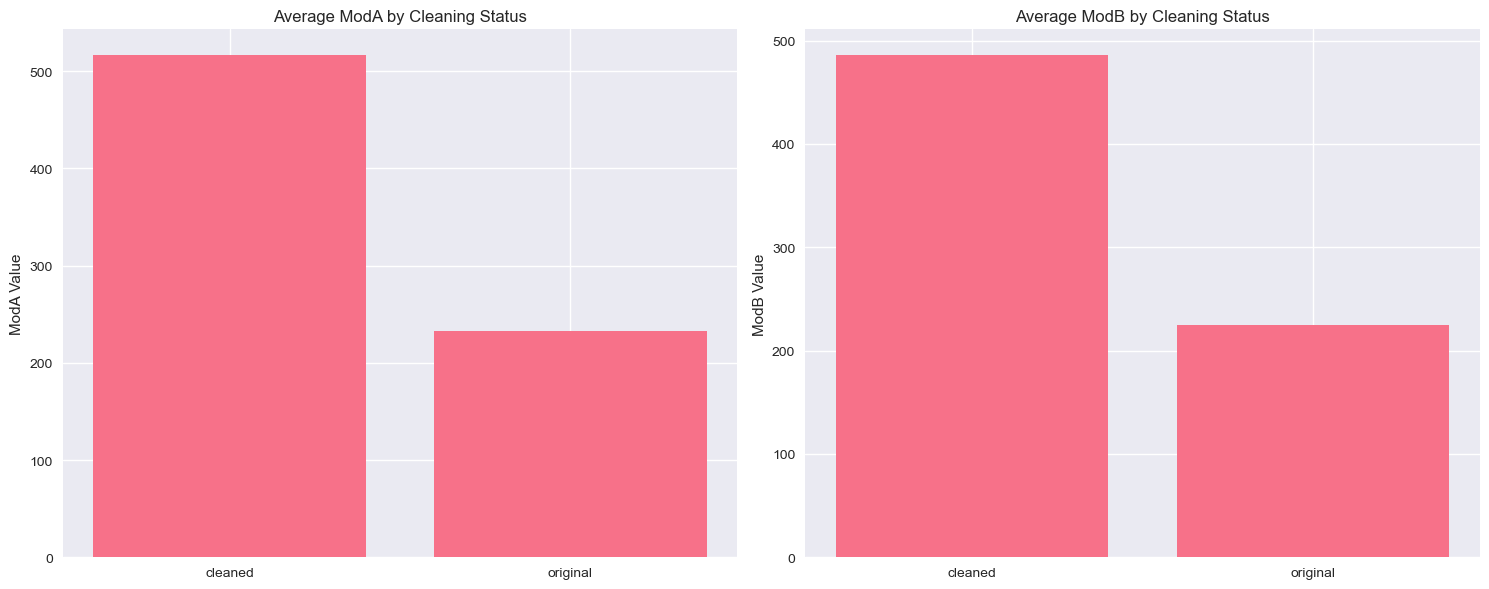

In [19]:
# Cell 6: Cleaning Impact Analysis
print("=== 5. CLEANING IMPACT ANALYSIS ===")

# Compare ModA and ModB before and after cleaning
if 'ModA' in benin_clean.columns and 'ModB' in benin_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ModA comparison
    cleaning_impact_moda = benin_clean.groupby('cleaning_flag')['ModA'].mean()
    axes[0].bar(cleaning_impact_moda.index, cleaning_impact_moda.values)
    axes[0].set_title('Average ModA by Cleaning Status')
    axes[0].set_ylabel('ModA Value')
    
    # ModB comparison
    cleaning_impact_modb = benin_clean.groupby('cleaning_flag')['ModB'].mean()
    axes[1].bar(cleaning_impact_modb.index, cleaning_impact_modb.values)
    axes[1].set_title('Average ModB by Cleaning Status')
    axes[1].set_ylabel('ModB Value')
    
    plt.tight_layout()
    plt.show()

=== 6. CORRELATION ANALYSIS ===


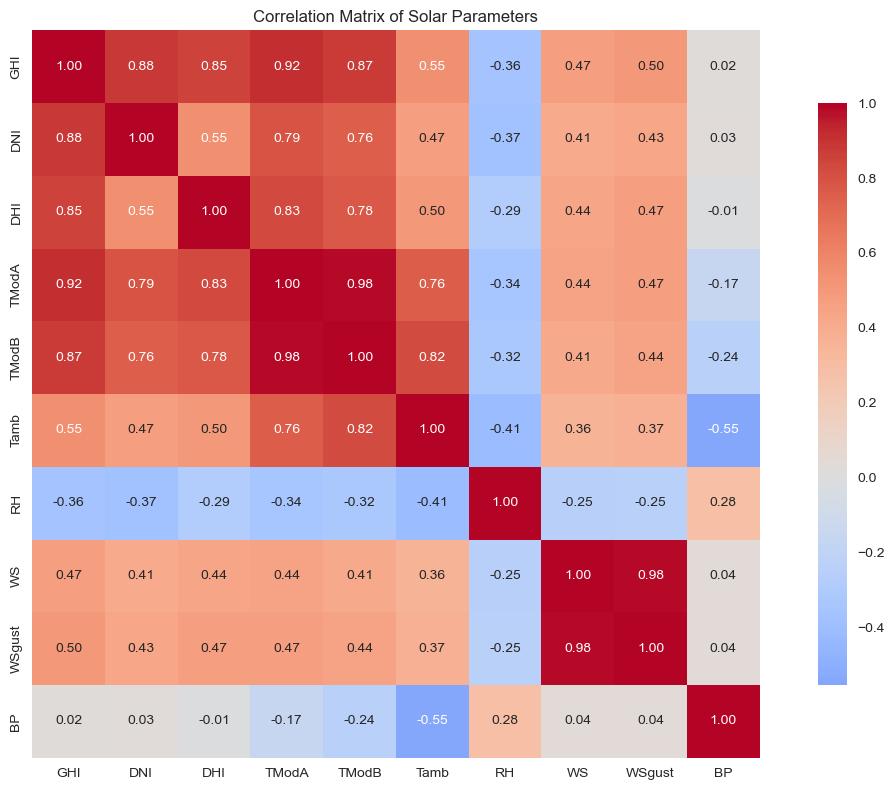

In [20]:
# Cell 7: Correlation Analysis
print("=== 6. CORRELATION ANALYSIS ===")

# Select numeric columns for correlation
correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust', 'BP']
correlation_cols = [col for col in correlation_cols if col in benin_clean.columns]

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = benin_clean[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Solar Parameters')
plt.tight_layout()
plt.show()

=== 7. SCATTER PLOTS ===


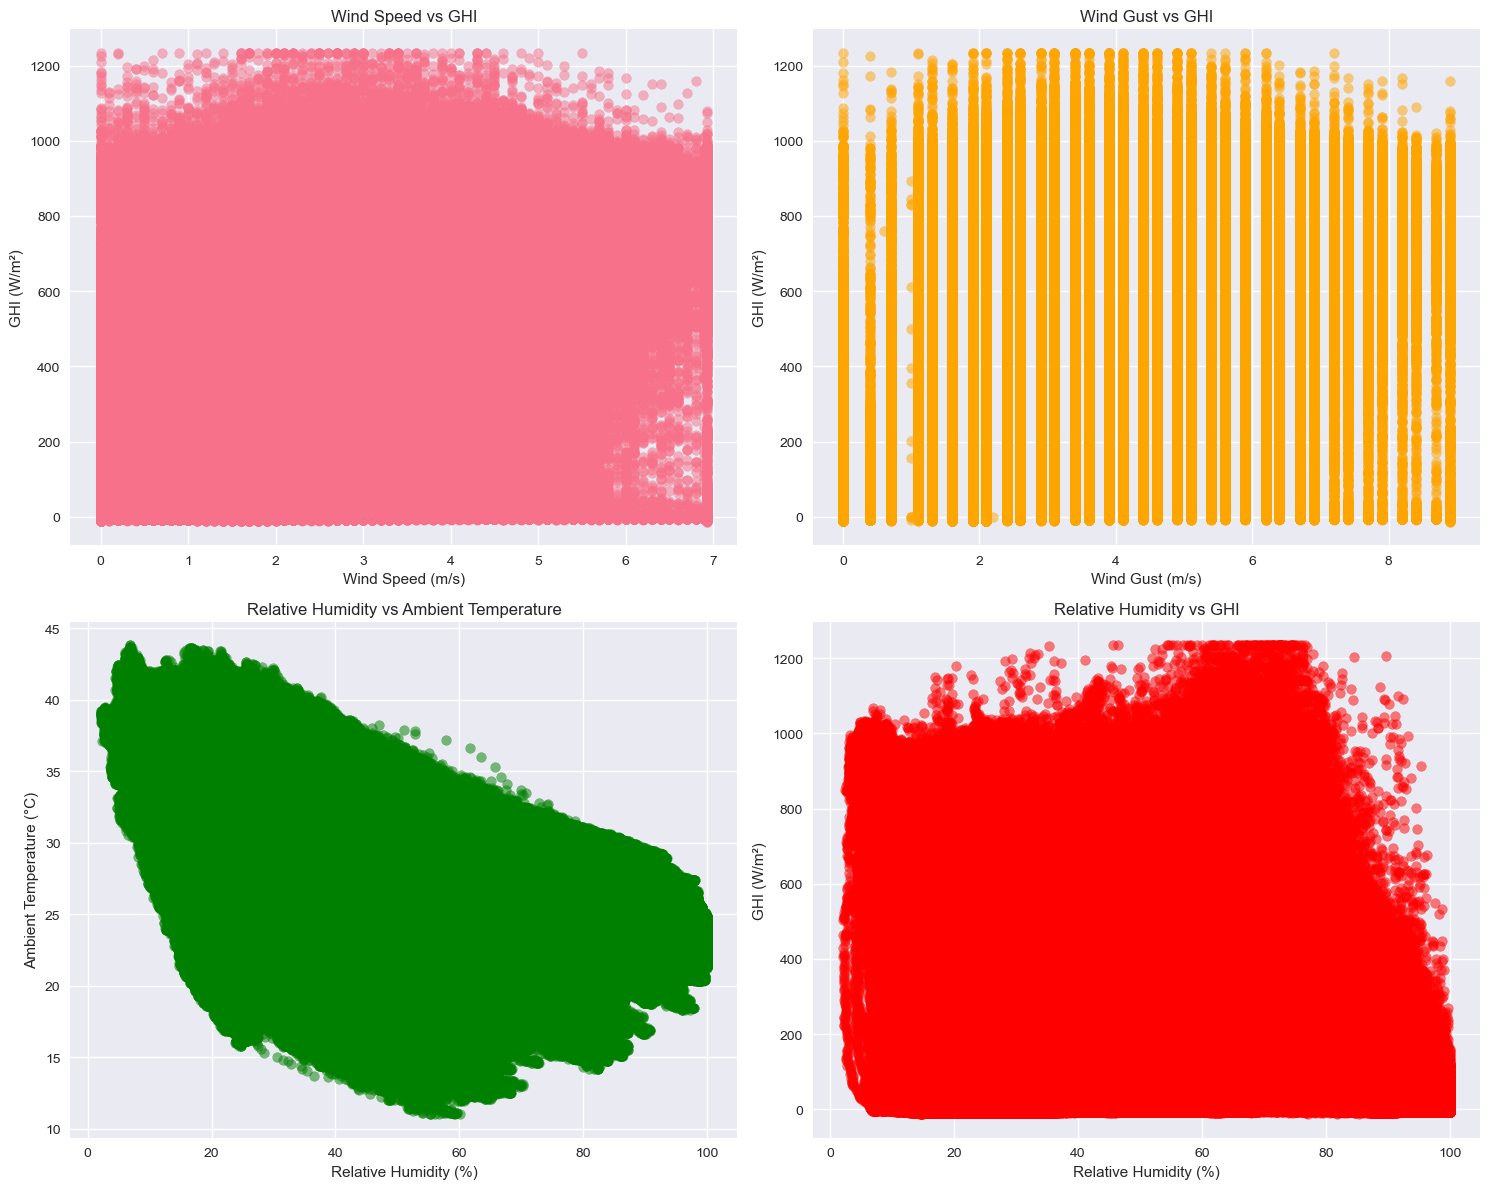

In [21]:
# Cell 8: Scatter Plots
print("=== 7. SCATTER PLOTS ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# WS vs GHI
if 'WS' in benin_clean.columns:
    axes[0,0].scatter(benin_clean['WS'], benin_clean['GHI'], alpha=0.5)
    axes[0,0].set_xlabel('Wind Speed (m/s)')
    axes[0,0].set_ylabel('GHI (W/m²)')
    axes[0,0].set_title('Wind Speed vs GHI')

# WSgust vs GHI
if 'WSgust' in benin_clean.columns:
    axes[0,1].scatter(benin_clean['WSgust'], benin_clean['GHI'], alpha=0.5, color='orange')
    axes[0,1].set_xlabel('Wind Gust (m/s)')
    axes[0,1].set_ylabel('GHI (W/m²)')
    axes[0,1].set_title('Wind Gust vs GHI')

# RH vs Tamb
if 'RH' in benin_clean.columns and 'Tamb' in benin_clean.columns:
    axes[1,0].scatter(benin_clean['RH'], benin_clean['Tamb'], alpha=0.5, color='green')
    axes[1,0].set_xlabel('Relative Humidity (%)')
    axes[1,0].set_ylabel('Ambient Temperature (°C)')
    axes[1,0].set_title('Relative Humidity vs Ambient Temperature')

# RH vs GHI
if 'RH' in benin_clean.columns:
    axes[1,1].scatter(benin_clean['RH'], benin_clean['GHI'], alpha=0.5, color='red')
    axes[1,1].set_xlabel('Relative Humidity (%)')
    axes[1,1].set_ylabel('GHI (W/m²)')
    axes[1,1].set_title('Relative Humidity vs GHI')

plt.tight_layout()
plt.show()

=== 8. DISTRIBUTION ANALYSIS ===


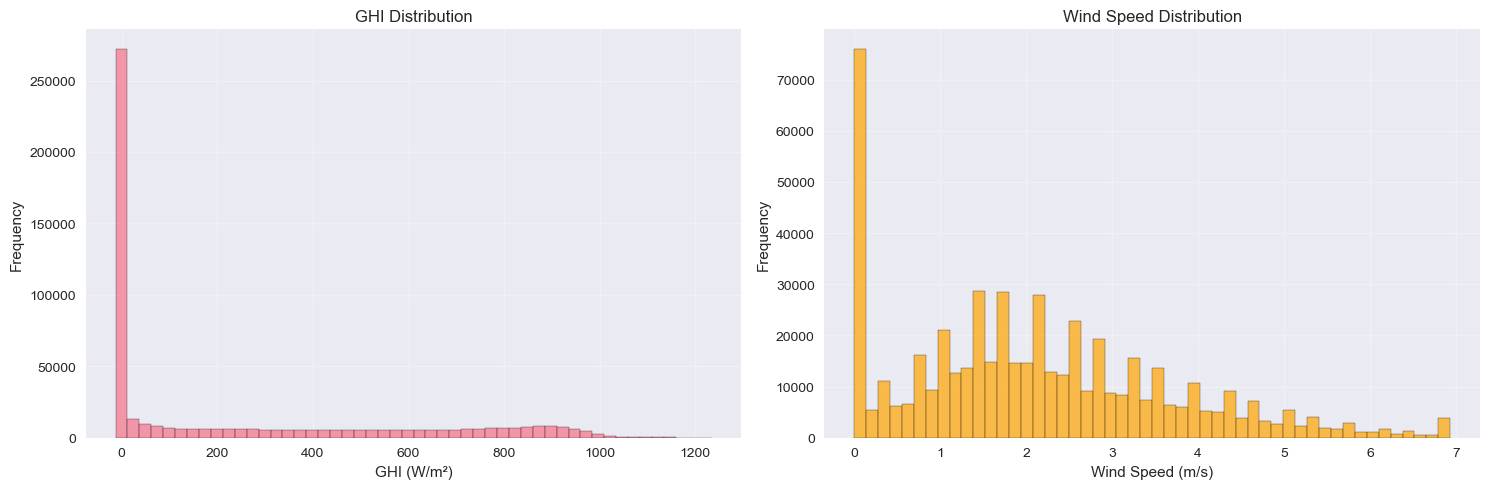

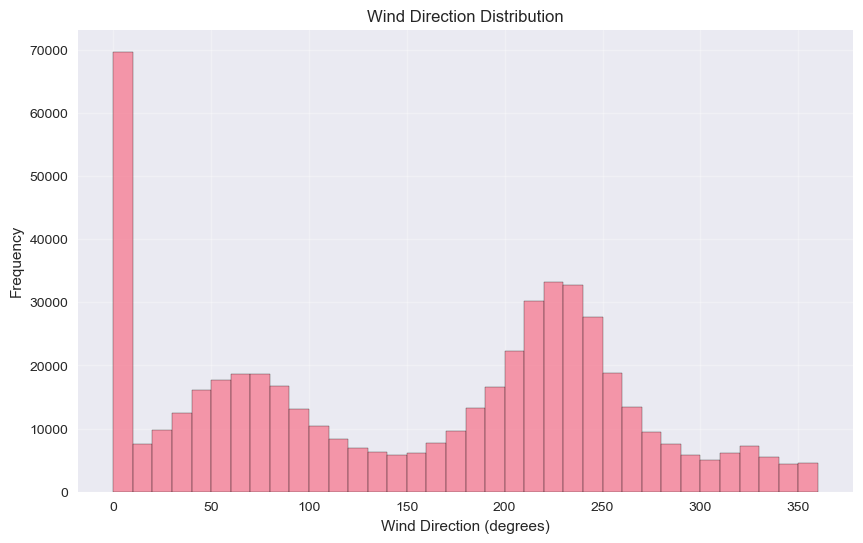

In [22]:
# Cell 9: Distribution Analysis
print("=== 8. DISTRIBUTION ANALYSIS ===")

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# GHI distribution
axes[0].hist(benin_clean['GHI'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('GHI (W/m²)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('GHI Distribution')
axes[0].grid(True, alpha=0.3)

# Wind Speed distribution
if 'WS' in benin_clean.columns:
    axes[1].hist(benin_clean['WS'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_xlabel('Wind Speed (m/s)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Wind Speed Distribution')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Simple wind direction analysis (if WD exists)
if 'WD' in benin_clean.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(benin_clean['WD'].dropna(), bins=36, alpha=0.7, edgecolor='black')
    plt.xlabel('Wind Direction (degrees)')
    plt.ylabel('Frequency')
    plt.title('Wind Direction Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

=== 9. TEMPERATURE ANALYSIS ===


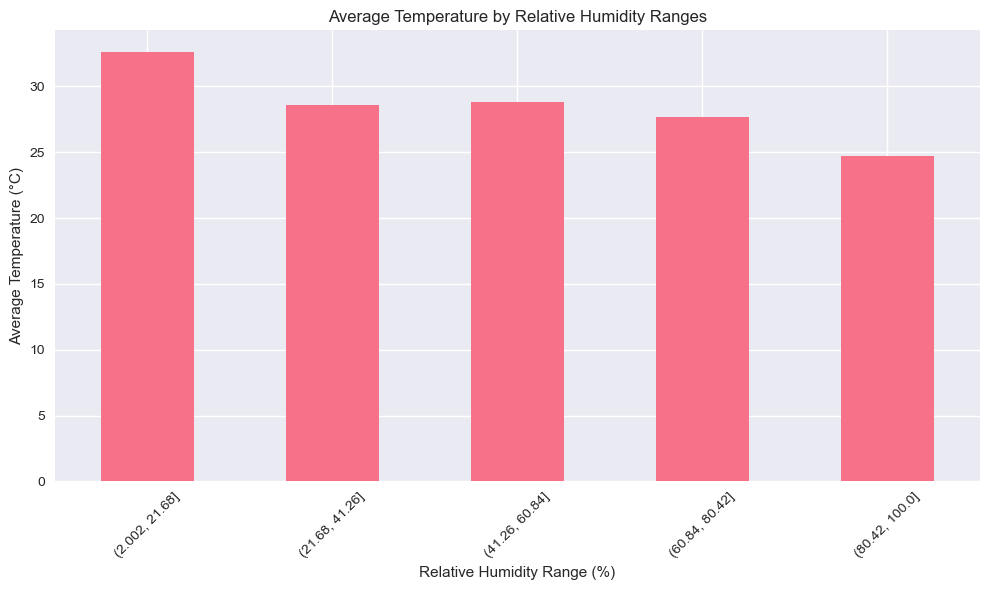

In [23]:
# Cell 10: Temperature Analysis
print("=== 9. TEMPERATURE ANALYSIS ===")

if 'RH' in benin_clean.columns and 'Tamb' in benin_clean.columns:
    # Analyze RH influence on temperature
    rh_bins = pd.cut(benin_clean['RH'], bins=5)
    temp_by_rh = benin_clean.groupby(rh_bins)['Tamb'].mean()
    
    plt.figure(figsize=(10, 6))
    temp_by_rh.plot(kind='bar')
    plt.title('Average Temperature by Relative Humidity Ranges')
    plt.xlabel('Relative Humidity Range (%)')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

=== 10. BUBBLE CHART ===


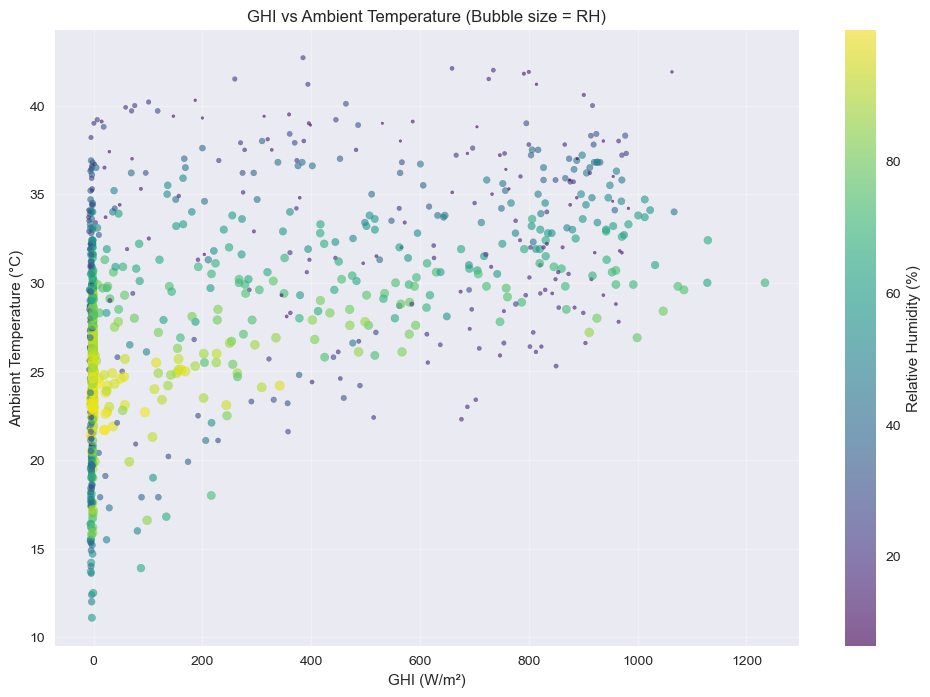

In [24]:
# Cell 11: Bubble Chart
print("=== 10. BUBBLE CHART ===")

# GHI vs Tamb with bubble size = RH
if all(col in benin_clean.columns for col in ['GHI', 'Tamb', 'RH']):
    plt.figure(figsize=(12, 8))
    
    # Sample data for better visualization if dataset is large
    sample_size = min(1000, len(benin_clean))
    sample_df = benin_clean.sample(sample_size, random_state=42)
    
    scatter = plt.scatter(sample_df['GHI'], sample_df['Tamb'], 
                         s=sample_df['RH']/2, alpha=0.6, 
                         c=sample_df['RH'], cmap='viridis')
    
    plt.colorbar(scatter, label='Relative Humidity (%)')
    plt.xlabel('GHI (W/m²)')
    plt.ylabel('Ambient Temperature (°C)')
    plt.title('GHI vs Ambient Temperature (Bubble size = RH)')
    plt.grid(True, alpha=0.3)
    plt.show()

In [27]:
# Cell 12: Export Cleaned Data
print("=== 11. EXPORTING CLEANED DATA ===")

# Reset index to include Timestamp as column
benin_clean_reset = benin_clean.reset_index()

# Export to CSV (ensure data/ is in .gitignore)
output_path = '../data/benin_clean.csv'
benin_clean_reset.to_csv(output_path, index=False)
print(f"Cleaned data exported to: {output_path}")

=== 11. EXPORTING CLEANED DATA ===
Cleaned data exported to: ../data/benin_clean.csv


In [28]:
# Cell 13: Key Insights Summary
print("=== 12. KEY INSIGHTS SUMMARY ===")

print("\nA. Data Quality Insights:")
print(f"   - Initial missing values: {benin_df.isnull().sum().sum()}")
print(f"   - Columns with >5% missing: {high_missing_cols}")
print(f"   - Outliers detected and handled: {outlier_flags.sum().sum()}")

print("\nB. Solar Radiation Patterns:")
print(f"   - Average GHI: {benin_clean['GHI'].mean():.2f} W/m²")
print(f"   - Average DNI: {benin_clean['DNI'].mean():.2f} W/m²") 
print(f"   - Average DHI: {benin_clean['DHI'].mean():.2f} W/m²")

print("\nC. Key Correlations:")
if 'GHI' in corr_matrix.columns and 'Tamb' in corr_matrix.columns:
    print(f"   - GHI vs Temperature: {corr_matrix.loc['GHI', 'Tamb']:.3f}")
if 'GHI' in corr_matrix.columns and 'RH' in corr_matrix.columns:
    print(f"   - GHI vs Relative Humidity: {corr_matrix.loc['GHI', 'RH']:.3f}")

print("\nD. Temperature Insights:")
print(f"   - Average Temperature: {benin_clean['Tamb'].mean():.2f} °C")
print(f"   - Temperature Range: {benin_clean['Tamb'].min():.2f} - {benin_clean['Tamb'].max():.2f} °C")

print("\nE. Wind Characteristics:")
if 'WS' in benin_clean.columns:
    print(f"   - Average Wind Speed: {benin_clean['WS'].mean():.2f} m/s")
if 'WSgust' in benin_clean.columns:
    print(f"   - Average Wind Gust: {benin_clean['WSgust'].mean():.2f} m/s")

print("\n" + "="*50)
print("TASK 2 COMPLETED SUCCESSFULLY!")

=== 12. KEY INSIGHTS SUMMARY ===

A. Data Quality Insights:
   - Initial missing values: 525600
   - Columns with >5% missing: ['Comments']
   - Outliers detected and handled: 10526

B. Solar Radiation Patterns:
   - Average GHI: 240.55 W/m²
   - Average DNI: 167.19 W/m²
   - Average DHI: 115.10 W/m²

C. Key Correlations:
   - GHI vs Temperature: 0.548
   - GHI vs Relative Humidity: -0.360

D. Temperature Insights:
   - Average Temperature: 28.18 °C
   - Temperature Range: 11.00 - 43.80 °C

E. Wind Characteristics:
   - Average Wind Speed: 2.11 m/s
   - Average Wind Gust: 2.80 m/s

TASK 2 COMPLETED SUCCESSFULLY!
